中級編で行ったhERG阻害活性の予測の一例を示す。

In [1]:
import numpy as np
import pandas as pd
import sys

from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn import svm
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import KFold, ShuffleSplit, GroupKFold, \
                                                                StratifiedKFold, StratifiedShuffleSplit,  \
                                                                LeaveOneOut, LeavePOut, \
                                                                cross_val_predict, cross_val_score, GridSearchCV


print(sys.version_info)

sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)


### 1. ChEMBLから抽出したhERG活性データの読み込み

advanced/data-set/trainingディレクトリにあるhERG-all.csvデータを読み込む。  
これはChEMBLからhERGに関するアッセイにて活性測定された化合物の情報が含まれている。  
データの抽出の仕方についてはこちらを参考にして欲しい。[Extract-hERG-assay-data-from-ChEMBL.ipynb](https://gist.github.com/yamasakih/62ef4b7396e1681f58a1c06543984c43)

In [2]:
df = pd.read_csv('data-set/training/hERG-all.csv', sep='\t')
df.head()

,Unnamed: 0,molregno,assay_chembl_id,description,assay_organism,assay_tissue,assay_cell_type,standard_relation,published_value,published_units,standard_value,standard_units,standard_type,activity_comment,published_type,data_validity_comment,published_relation,pchembl_value,standard_inchi,canonical_smiles
0,0,112651,CHEMBL656604,K+ channel blocking activity in COS-7 African ...,Homo sapiens,NaN,COS-7,=,550.0,nM,550.0,nM,IC50,NaN,IC50,NaN,=,6.26,InChI=1S/C24H34N2O/c1-21(2)19-27-20-24(25-15-9...,CC(C)COCC(CN(Cc1ccccc1)c2ccccc2)N3CCCC3
1,1,65351,CHEMBL875385,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,34400.0,nM,34400.0,nM,IC50,NaN,IC50,NaN,=,4.46,InChI=1S/C19H22F2N4O3/c1-8-5-24(6-9(2)23-8)17-...,C[C@@H]1CN(C[C@H](C)N1)c2c(F)c(N)c3C(=O)C(=CN(...
2,2,6216,CHEMBL662311,K+ channel blocking activity in Chinese hamste...,Homo sapiens,NaN,NaN,=,1470.0,nM,1470.0,nM,IC50,NaN,IC50,NaN,=,5.83,InChI=1S/C17H19ClN2S/c1-19(2)10-5-11-20-14-6-3...,CN(C)CCCN1c2ccccc2Sc3ccc(Cl)cc13
3,3,1543376,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,5950.0,nM,5950.0,nM,IC50,NaN,IC50,NaN,=,5.23,InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-...,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...
4,4,65605,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,0.9,nM,0.9,nM,IC50,NaN,IC50,NaN,=,9.05,InChI=1S/C28H31FN4O/c1-34-25-12-8-21(9-13-25)1...,COc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5...


サンプル数とカラムの数を `shpae` を用いて確認する。

In [3]:
df.shape

(7016, 20)

サンプル数は7016, カラム数は20であった。  
続いて先頭のカラムが不要なので削除する。まずカラムの名前を再度確認してみる。

In [4]:
df.columns

Index(['Unnamed: 0', 'molregno', 'assay_chembl_id', 'description',
       'assay_organism', 'assay_tissue', 'assay_cell_type',
       'standard_relation', 'published_value', 'published_units',
       'standard_value', 'standard_units', 'standard_type', 'activity_comment',
       'published_type', 'data_validity_comment', 'published_relation',
       'pchembl_value', 'standard_inchi', 'canonical_smiles'],
      dtype='object')

先頭のカラムの名前は `Unnamed: 0` であった。 `drop` メソッドを用いて削除する。  
`drop` メソッドにはカラムの名前を指定する必要がある。

In [5]:
df.drop('Unnamed: 0', axis=1).head()

,molregno,assay_chembl_id,description,assay_organism,assay_tissue,assay_cell_type,standard_relation,published_value,published_units,standard_value,standard_units,standard_type,activity_comment,published_type,data_validity_comment,published_relation,pchembl_value,standard_inchi,canonical_smiles
0,112651,CHEMBL656604,K+ channel blocking activity in COS-7 African ...,Homo sapiens,NaN,COS-7,=,550.0,nM,550.0,nM,IC50,NaN,IC50,NaN,=,6.26,InChI=1S/C24H34N2O/c1-21(2)19-27-20-24(25-15-9...,CC(C)COCC(CN(Cc1ccccc1)c2ccccc2)N3CCCC3
1,65351,CHEMBL875385,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,34400.0,nM,34400.0,nM,IC50,NaN,IC50,NaN,=,4.46,InChI=1S/C19H22F2N4O3/c1-8-5-24(6-9(2)23-8)17-...,C[C@@H]1CN(C[C@H](C)N1)c2c(F)c(N)c3C(=O)C(=CN(...
2,6216,CHEMBL662311,K+ channel blocking activity in Chinese hamste...,Homo sapiens,NaN,NaN,=,1470.0,nM,1470.0,nM,IC50,NaN,IC50,NaN,=,5.83,InChI=1S/C17H19ClN2S/c1-19(2)10-5-11-20-14-6-3...,CN(C)CCCN1c2ccccc2Sc3ccc(Cl)cc13
3,1543376,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,5950.0,nM,5950.0,nM,IC50,NaN,IC50,NaN,=,5.23,InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-...,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...
4,65605,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,0.9,nM,0.9,nM,IC50,NaN,IC50,NaN,=,9.05,InChI=1S/C28H31FN4O/c1-34-25-12-8-21(9-13-25)1...,COc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5...


以下のような指定の仕方でも削除することができる。まとめて削除するときなどはこちらの方が楽かもしれない。

In [6]:
df.columns[[0]]

Index(['Unnamed: 0'], dtype='object')

In [7]:
df.drop(df.columns[[0]], axis=1).head()

,molregno,assay_chembl_id,description,assay_organism,assay_tissue,assay_cell_type,standard_relation,published_value,published_units,standard_value,standard_units,standard_type,activity_comment,published_type,data_validity_comment,published_relation,pchembl_value,standard_inchi,canonical_smiles
0,112651,CHEMBL656604,K+ channel blocking activity in COS-7 African ...,Homo sapiens,NaN,COS-7,=,550.0,nM,550.0,nM,IC50,NaN,IC50,NaN,=,6.26,InChI=1S/C24H34N2O/c1-21(2)19-27-20-24(25-15-9...,CC(C)COCC(CN(Cc1ccccc1)c2ccccc2)N3CCCC3
1,65351,CHEMBL875385,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,34400.0,nM,34400.0,nM,IC50,NaN,IC50,NaN,=,4.46,InChI=1S/C19H22F2N4O3/c1-8-5-24(6-9(2)23-8)17-...,C[C@@H]1CN(C[C@H](C)N1)c2c(F)c(N)c3C(=O)C(=CN(...
2,6216,CHEMBL662311,K+ channel blocking activity in Chinese hamste...,Homo sapiens,NaN,NaN,=,1470.0,nM,1470.0,nM,IC50,NaN,IC50,NaN,=,5.83,InChI=1S/C17H19ClN2S/c1-19(2)10-5-11-20-14-6-3...,CN(C)CCCN1c2ccccc2Sc3ccc(Cl)cc13
3,1543376,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,5950.0,nM,5950.0,nM,IC50,NaN,IC50,NaN,=,5.23,InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-...,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...
4,65605,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,0.9,nM,0.9,nM,IC50,NaN,IC50,NaN,=,9.05,InChI=1S/C28H31FN4O/c1-34-25-12-8-21(9-13-25)1...,COc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5...


上記のいずれかの方法で削除したものを再び `df` という名前で保存しておく。

In [8]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,molregno,assay_chembl_id,description,assay_organism,assay_tissue,assay_cell_type,standard_relation,published_value,published_units,standard_value,standard_units,standard_type,activity_comment,published_type,data_validity_comment,published_relation,pchembl_value,standard_inchi,canonical_smiles
0,112651,CHEMBL656604,K+ channel blocking activity in COS-7 African ...,Homo sapiens,NaN,COS-7,=,550.0,nM,550.0,nM,IC50,NaN,IC50,NaN,=,6.26,InChI=1S/C24H34N2O/c1-21(2)19-27-20-24(25-15-9...,CC(C)COCC(CN(Cc1ccccc1)c2ccccc2)N3CCCC3
1,65351,CHEMBL875385,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,34400.0,nM,34400.0,nM,IC50,NaN,IC50,NaN,=,4.46,InChI=1S/C19H22F2N4O3/c1-8-5-24(6-9(2)23-8)17-...,C[C@@H]1CN(C[C@H](C)N1)c2c(F)c(N)c3C(=O)C(=CN(...
2,6216,CHEMBL662311,K+ channel blocking activity in Chinese hamste...,Homo sapiens,NaN,NaN,=,1470.0,nM,1470.0,nM,IC50,NaN,IC50,NaN,=,5.83,InChI=1S/C17H19ClN2S/c1-19(2)10-5-11-20-14-6-3...,CN(C)CCCN1c2ccccc2Sc3ccc(Cl)cc13
3,1543376,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,5950.0,nM,5950.0,nM,IC50,NaN,IC50,NaN,=,5.23,InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-...,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...
4,65605,CHEMBL691013,K+ channel blocking activity in human embryoni...,Homo sapiens,NaN,NaN,=,0.9,nM,0.9,nM,IC50,NaN,IC50,NaN,=,9.05,InChI=1S/C28H31FN4O/c1-34-25-12-8-21(9-13-25)1...,COc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5...


### 2. 活性値データのしぼりこみ

今回のデータはすでに`assay_organism=Homo sapiens`, `puslished_type=IC50`でしぼりこんでいるが、  
どういう流れでしぼりこんだらよいかを示すためにしぼりこんでみる。  
Pandasの`DataFrame`では以下のようにすることで特定の条件でサンプルをしぼりこむことができる。  

#### 2.1 assay_organism=Homo sapiensでしぼりこむ

以下のようにすることで特定のカラムのデータだけ取り出すことができる。

In [9]:
df['assay_organism']

0       Homo sapiens
1       Homo sapiens
2       Homo sapiens
3       Homo sapiens
4       Homo sapiens
5       Homo sapiens
6       Homo sapiens
7       Homo sapiens
8       Homo sapiens
9       Homo sapiens
10      Homo sapiens
11      Homo sapiens
12      Homo sapiens
13      Homo sapiens
14      Homo sapiens
15      Homo sapiens
16      Homo sapiens
17      Homo sapiens
18      Homo sapiens
19      Homo sapiens
20      Homo sapiens
21      Homo sapiens
22      Homo sapiens
23      Homo sapiens
24      Homo sapiens
25      Homo sapiens
26      Homo sapiens
27      Homo sapiens
28      Homo sapiens
29      Homo sapiens
            ...     
6986    Homo sapiens
6987    Homo sapiens
6988    Homo sapiens
6989    Homo sapiens
6990    Homo sapiens
6991    Homo sapiens
6992    Homo sapiens
6993    Homo sapiens
6994    Homo sapiens
6995    Homo sapiens
6996    Homo sapiens
6997    Homo sapiens
6998    Homo sapiens
6999    Homo sapiens
7000    Homo sapiens
7001    Homo sapiens
7002    Homo 

さらに比較演算子を適用して、`True`や`False`に変換することができる。  
今回は`Homo sapiens`と一致しているなら`True`, 一致していないなら`False`を返している。

In [10]:
df['assay_organism'] == 'Homo sapiens'

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
6986    True
6987    True
6988    True
6989    True
6990    True
6991    True
6992    True
6993    True
6994    True
6995    True
6996    True
6997    True
6998    True
6999    True
7000    True
7001    True
7002    True
7003    True
7004    True
7005    True
7006    True
7007    True
7008    True
7009    True
7010    True
7011    True
7012    True
7013    True
7014    True
7015    True
Name: assay_organism, Length: 7016, dtype: bool

この`True`,　`False`の2値情報を用いるとサンプルをしぼりこむことができる。  
`DataFrame`の[loc](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html)メソッドでは`True`の行は残し、`False`の行は取り除くというルールがあるからである。  
したがって以下のようにスクリプトを書くと`assay_organism=Homo sapiens`という条件でしぼりこみ  
再び`df`という名前で保存することができる。

In [11]:
df = df.loc[df['assay_organism'] == 'Homo sapiens', :]

#### 2.2 published_value=IC50でしぼりこむ

2.1同様に`published_type=IC50`のものでしぼりこむ

In [12]:
df['published_type'] == 'IC50'

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
6986    True
6987    True
6988    True
6989    True
6990    True
6991    True
6992    True
6993    True
6994    True
6995    True
6996    True
6997    True
6998    True
6999    True
7000    True
7001    True
7002    True
7003    True
7004    True
7005    True
7006    True
7007    True
7008    True
7009    True
7010    True
7011    True
7012    True
7013    True
7014    True
7015    True
Name: published_type, Length: 7016, dtype: bool

In [13]:
df = df.loc[df['published_type'] == 'IC50', :]

#### 2.3 standard_relation='='でしぼりこむ

standard_relationには活性値が不等号表記されている`>`,`<`など、そうでないなら`=`が保存されている。  
2.1, 2.2同様に`standard_relation='='`のものでしぼりこむ

In [14]:
df['standard_relation'] == '='

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27      False
28       True
29       True
        ...  
6986     True
6987    False
6988    False
6989     True
6990     True
6991     True
6992     True
6993     True
6994    False
6995     True
6996     True
6997     True
6998    False
6999     True
7000     True
7001     True
7002     True
7003     True
7004     True
7005     True
7006     True
7007     True
7008     True
7009     True
7010     True
7011    False
7012    False
7013    False
7014    False
7015    False
Name: standard_relation, Length: 7016, dtype: bool

`False`となっているものがちらほらあるので、いくつか不等号表記されているものがあるようだ。  
この条件でデータをしぼってものを再び`df`という名前で保存する。

In [15]:
df = df.loc[df['standard_relation'] == '=', :]

In [16]:
df.shape

(4647, 19)

3個のしぼりこみを行いサンプルが4647個まで減った。こちらのデータに続けて解析を行っていく。  
最後に今後必要である活性値とcanonical smilesのみにしておく。今回は活性値として`pchembl_value`を使ってみる。

In [17]:
df = df.loc[:, ['canonical_smiles', 'pchembl_value']]
df.head()

,canonical_smiles,pchembl_value
0,CC(C)COCC(CN(Cc1ccccc1)c2ccccc2)N3CCCC3,6.26
1,C[C@@H]1CN(C[C@H](C)N1)c2c(F)c(N)c3C(=O)C(=CN(...,4.46
2,CN(C)CCCN1c2ccccc2Sc3ccc(Cl)cc13,5.83
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,5.23
4,COc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5...,9.05


### 3. 構造記述子計算

`RDKit` を用いて構造記述子を計算する。

#### 3.1 canonical smilesからRDKitのMolオブジェクトへの変換

In [18]:
smiles_set = df['canonical_smiles']
smiles_set[:5]

0              CC(C)COCC(CN(Cc1ccccc1)c2ccccc2)N3CCCC3
1    C[C@@H]1CN(C[C@H](C)N1)c2c(F)c(N)c3C(=O)C(=CN(...
2                     CN(C)CCCN1c2ccccc2Sc3ccc(Cl)cc13
3    O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...
4    COc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5...
Name: canonical_smiles, dtype: object

`In[18]`の出力が`dtype: object`と書かれているのようにsmilesキーはうまく文字列として認識されていない。  
こういう時は`DataFrame`クラスの`to_string`メソッドを用いるとよい。

In [19]:
mols = np.array([Chem.MolFromSmiles(smiles) for smiles in smiles_set if Chem.MolFromSmiles(smiles) is not None])
mols.size

4647

うまくすべてのcanonical smilesをMolオブジェクトに変換できたようだ。いくつかの化学構造を図にしてみる。

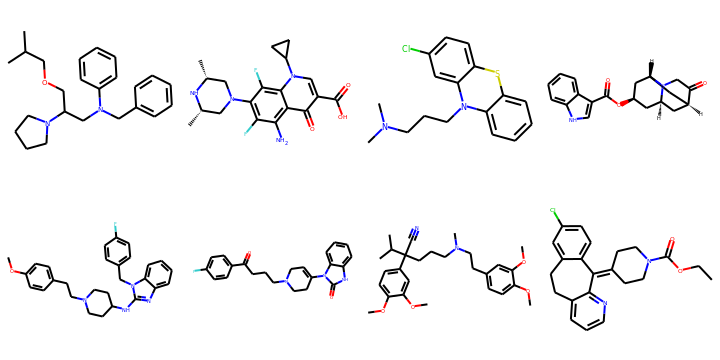

In [20]:
Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(180, 180))

#### 3.2 構造記述子計算

今回はRDKit (version 2017.03.3) で計算可能な196個の記述子すべてを計算する。

In [21]:
names = [x[0] for x in Descriptors._descList]
names[:5]

['MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons']

少し時間がかかりそうなので参考までに`%%time`をつけて計算時間を測定しておく。

In [22]:
%%time
calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
descs = [calc.CalcDescriptors(mol) for mol in mols]
descs

CPU times: user 1min 5s, sys: 510 ms, total: 1min 6s
Wall time: 1min 6s


私のパソコンでは約1分で計算が終わった。  
最後に機械学習で用いるためにデータフレームに変換しておく。

In [23]:
descs = pd.DataFrame(descs, columns=names)
descs.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,MaxEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,366.549,332.277,366.267114,146,0,0.063870,-0.379488,0.379488,0.063870,6.088269,...,0,0,0,0,0,0,0,0,0,0
1,392.406,370.230,392.165997,150,0,0.340725,-0.477497,0.477497,0.340725,15.645307,...,0,0,0,0,0,0,0,0,0,0
2,318.873,299.721,318.095747,110,0,0.056730,-0.339551,0.339551,0.056730,6.209384,...,0,0,0,0,0,0,0,0,0,0
3,324.380,304.220,324.147393,124,0,0.340086,-0.458602,0.458602,0.340086,12.609635,...,0,0,0,0,0,0,0,0,0,0
4,458.581,427.333,458.248190,176,0,0.203922,-0.496768,0.496768,0.203922,13.380037,...,0,0,0,0,0,0,0,0,0,0


これらのデータを説明変数として、2で作成したデータの`pchembl_value`を目的変数として機械学習を行っていく。

### 4. 前処理

#### 4.1 オートスケーリング

#### 4.1.1 説明変数

説明変数`descs`のオートスケーリングを行う。  
`descs_scaled`と言ったような名前に変えてもいいが今回はそのまま`descs`に代入する。  
あくまで参考だが私はやり直す可能性がないデータは名前を変えずそのまま代入していく。

In [24]:
descs = (descs - descs.mean() / descs.std(ddof=1))
descs.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,MaxEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,361.299706,327.100202,361.020187,140.86382,NaN,-2.619067,5.476753,-5.629209,-2.887059,1.838898,...,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,NaN,-0.185178,-0.253098,-0.254627
1,387.156706,365.053202,386.919070,144.86382,NaN,-2.342212,5.378744,-5.531200,-2.610204,11.395936,...,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,NaN,-0.185178,-0.253098,-0.254627
2,313.623706,294.544202,312.848821,104.86382,NaN,-2.626206,5.516690,-5.669146,-2.894198,1.960013,...,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,NaN,-0.185178,-0.253098,-0.254627
3,319.130706,299.043202,318.900466,118.86382,NaN,-2.342851,5.397639,-5.550095,-2.610842,8.360264,...,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,NaN,-0.185178,-0.253098,-0.254627
4,453.331706,422.156202,453.001263,170.86382,NaN,-2.479015,5.359473,-5.511929,-2.747007,9.130666,...,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,NaN,-0.185178,-0.253098,-0.254627


NumRadicalElectronsなど分散が0だったカラムは0で割る処理がされたため  
値がすべて`NaN`(=Not an Number)になっている。これらのカラムを`dropna`メソッドを使って取り除く。

In [25]:
descs = descs.dropna(axis=1)
descs.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,MaxEStateIndex,MinEStateIndex,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,361.299706,327.100202,361.020187,140.86382,-2.619067,5.476753,-5.629209,-2.887059,1.838898,1.136721,...,-0.038837,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,-0.185178,-0.253098,-0.254627
1,387.156706,365.053202,386.919070,144.86382,-2.342212,5.378744,-5.531200,-2.610204,11.395936,-0.752002,...,-0.038837,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,-0.185178,-0.253098,-0.254627
2,313.623706,294.544202,312.848821,104.86382,-2.626206,5.516690,-5.669146,-2.894198,1.960013,1.494288,...,-0.038837,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,-0.185178,-0.253098,-0.254627
3,319.130706,299.043202,318.900466,118.86382,-2.342851,5.397639,-5.550095,-2.610842,8.360264,0.454769,...,-0.038837,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,-0.185178,-0.253098,-0.254627
4,453.331706,422.156202,453.001263,170.86382,-2.479015,5.359473,-5.511929,-2.747007,9.130666,0.485027,...,-0.038837,-0.145385,-0.216082,-0.194207,-0.020748,-0.141313,-0.196145,-0.185178,-0.253098,-0.254627


196個あった記述子が173個まで減ったので分散が0のカラムが23個あったことになる。

#### 4.1.1 目的変数

目的変数`df`の`pchembl_value`のオートスケーリングを行う。  

In [26]:
y = df['pchembl_value']
y = (y - y.mean()) / y.std()
y[:5]

0    0.816378
1   -1.105193
2    0.357336
3   -0.283187
4    3.794812
Name: pchembl_value, dtype: float64

#### 4.2 multicollinearityのある記述子を取り除く

multicollinearityいわゆる多重共線性のある記述子のどちらかを自動で取り除くためのクラスや関数は  
残念ながらscikit-learnにはないので今回は以下のように自分でスクリプトを書いてみた。

##### 4.2.1 説明変数の相関行列を計算する

`DataFrame`クラスの`corr`メソッドを用いると説明変数の相関行列を計算することができる。

In [27]:
descs_corrs = descs.corr()
descs_corrs.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,MaxEStateIndex,MinEStateIndex,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
MolWt,1.000000,0.997855,0.999992,0.978995,0.454668,-0.214087,0.259684,0.479082,0.470472,-0.370407,...,0.033287,-0.007026,0.108797,0.120240,-0.020728,0.034808,-0.027060,-0.022277,-0.020587,0.108825
HeavyAtomMolWt,0.997855,1.000000,0.997800,0.968584,0.470533,-0.216103,0.265242,0.494206,0.477334,-0.386770,...,0.030196,-0.003516,0.107967,0.122589,-0.019391,0.038960,-0.023952,-0.018624,-0.037922,0.105490
ExactMolWt,0.999992,0.997800,1.000000,0.979596,0.455488,-0.214487,0.260264,0.479868,0.471100,-0.371039,...,0.033014,-0.007075,0.108643,0.120269,-0.020693,0.035014,-0.026920,-0.022251,-0.020603,0.108580
NumValenceElectrons,0.978995,0.968584,0.979596,1.000000,0.464222,-0.230137,0.277508,0.488588,0.483644,-0.360979,...,0.018008,-0.033380,0.080624,0.093994,-0.022014,0.038466,-0.051347,-0.051331,0.000859,0.104741
MaxPartialCharge,0.454668,0.470533,0.455488,0.464222,1.000000,-0.139217,0.337672,0.973350,0.530847,-0.694258,...,-0.040312,-0.058149,0.020312,0.003839,-0.001777,0.086750,-0.034394,-0.084791,-0.154270,0.189087


##### 4.2.2 説明変数と目的変数の間の相関を計算する 

続けて説明変数と目的変数の間の相関を`corrwith`メソッドを使って求めてみる。

In [28]:
descs_y_corr = descs.corrwith(y)
descs_y_corr[:10]

MolWt                  0.002938
HeavyAtomMolWt        -0.000187
ExactMolWt             0.002889
NumValenceElectrons    0.005075
MaxPartialCharge       0.001686
MinPartialCharge       0.039221
MaxAbsPartialCharge   -0.036133
MinAbsPartialCharge   -0.000883
MaxEStateIndex        -0.021895
MinEStateIndex        -0.001181
dtype: float64

目的変数と線形相関を持つ説明変数は非常に少なさそうだ。

##### 4.2.3 相関に基づいて記述子を選択する

1. 目的変数と最も相関をもつ説明変数を取り出す
2. その説明変数との相関の絶対値が(今回は)0.6以上の説明変数を取り除く
3. 1-2を繰り返す

というスクリプトは以下のようになる。

In [29]:
feature_names = descs.columns.tolist()
feature_names[:5]

['MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge']

In [30]:
selected_feature_names = []

In [31]:
while feature_names:
    #feature_namesに含まれる説明変数に関するデータのみにしぼりこむ
    tmp_descs_corrs = descs_corrs.loc[feature_names, feature_names]
    tmp_descs_y_corr = descs_y_corr.loc[feature_names]
    
    #目的変数と最も相関のある説明変数の名前を取り出す
    max_desc_name = tmp_descs_y_corr.idxmax()
    
    #相関行列から目的変数と最も相関のある説明変数との間の相関のみを取り出す
    corr = tmp_descs_corrs.drop(max_desc_name, axis=1).loc[max_desc_name, :]
    
    #基準値(今回は0.6)未満の相関係数の説明変数の名前を新たなfeature_nameとして保存する。
    remain_corr = corr[abs(corr) < 0.6]
    feature_names = remain_corr.index.tolist()
    
    #目的変数と最も相関のある説明変数の名前をselected_feature_namesに追加する
    selected_feature_names.append(max_desc_name)

print(selected_feature_names)

['EState_VSA4', 'fr_Ndealkylation2', 'fr_Al_OH', 'PEOE_VSA7', 'fr_imidazole', 'SMR_VSA6', 'NumAromaticCarbocycles', 'fr_piperdine', 'PEOE_VSA14', 'PEOE_VSA8', 'Kappa3', 'fr_ketone_Topliss', 'HallKierAlpha', 'SMR_VSA10', 'MinPartialCharge', 'fr_Ar_NH', 'fr_urea', 'fr_NH1', 'PEOE_VSA1', 'fr_SH', 'fr_para_hydroxylation', 'EState_VSA8', 'fr_halogen', 'fr_piperzine', 'fr_Al_COO', 'MinAbsEStateIndex', 'FractionCSP3', 'PEOE_VSA5', 'fr_hdrzine', 'MolLogP', 'SlogP_VSA8', 'fr_amide', 'fr_methoxy', 'Chi4n', 'fr_phenol', 'fr_C_S', 'fr_alkyl_carbamate', 'fr_term_acetylene', 'EState_VSA5', 'NumSaturatedHeterocycles', 'PEOE_VSA2', 'fr_sulfide', 'EState_VSA7', 'fr_ArN', 'fr_HOCCN', 'fr_thiophene', 'fr_oxime', 'fr_N_O', 'fr_hdrzone', 'fr_Ar_COO', 'fr_furan', 'EState_VSA1', 'fr_ester', 'fr_oxazole', 'fr_Ndealkylation1', 'SMR_VSA3', 'VSA_EState5', 'PEOE_VSA11', 'fr_sulfonamd', 'fr_lactam', 'VSA_EState10', 'fr_quatN', 'fr_sulfone', 'fr_nitro', 'SMR_VSA2', 'fr_dihydropyridine', 'Ipc', 'fr_morpholine', 'PEO

In [32]:
len(selected_feature_names)

97

全部で97個の説明変数が残った。  
最後にこれらの説明変数のみのカラム`descs`から取り出し`X`という名前で保存しておく。

In [33]:
X = descs.loc[:, selected_feature_names]
X.head()

,EState_VSA4,fr_Ndealkylation2,fr_Al_OH,PEOE_VSA7,fr_imidazole,SMR_VSA6,NumAromaticCarbocycles,fr_piperdine,PEOE_VSA14,PEOE_VSA8,...,fr_amidine,EState_VSA11,fr_unbrch_alkane,EState_VSA3,PEOE_VSA3,SlogP_VSA4,fr_NH2,SMR_VSA9,EState_VSA6,SMR_VSA4
0,24.318767,0.225331,-0.351096,46.591547,-0.366611,36.031254,0.179775,-0.67449,-0.617210,23.141575,...,-0.180785,-0.142380,-0.253098,10.474948,-1.177499,4.910980,-0.383289,-1.099193,-1.163549,5.277007
1,17.053977,-0.774669,-0.351096,23.735417,-0.366611,22.006402,-0.820225,-0.67449,5.352095,35.169673,...,-0.180785,8.638451,-0.253098,11.604714,12.397868,10.627515,0.616711,-1.099193,3.736361,-0.640900
2,22.548458,-0.774669,-0.351096,54.439057,-0.366611,30.368078,0.179775,-0.67449,-0.617210,19.116151,...,-0.180785,-0.142380,-0.253098,-1.484799,-1.177499,-1.006926,-0.383289,-1.099193,-1.163549,-0.640900
3,34.601701,-0.774669,-0.351096,15.954310,-0.366611,4.828068,-0.820225,3.32551,5.352095,45.700794,...,-0.180785,-0.142380,-0.253098,28.490336,3.617038,4.910980,-0.383289,-1.099193,5.033295,5.277007
4,65.206928,0.225331,-0.351096,63.833870,0.633389,30.344167,1.179775,0.32551,-0.617210,23.433904,...,-0.180785,-0.142380,-0.253098,11.101798,8.196895,4.810295,-0.383289,4.650318,5.946249,-0.640900
